In [75]:

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
import keras.optimizers
import keras.backend as K
import tensorflow as tf
#from keras.optimizers import RMSprop, SGD
from matplotlib import pyplot as plt
import numpy as np
import pickle
import math

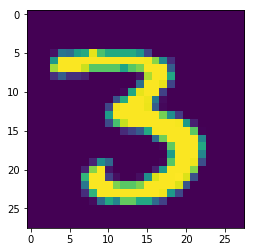

60000 train samples
10000 test samples


In [2]:
num_classes=10
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
fig = plt.imshow(x_train[12])
plt.show()
#plt.savefig('mnist-example.png')
plt.imsave('mnist-example1.png',x_train[10])
plt.imsave('mnist-example2.png',x_train[11])
plt.imsave('mnist-example3.png',x_train[12])

#Process Data
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [3]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Callback Function for Learning Rate Plots
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr = []
        self.lr_avg = []
        
    def on_epoch_end(self,batch, logs={}):
        
        optimizer = self.model.optimizer
        lrt = K.eval(optimizer.lr)
        
        self.lr.append(lrt)
        self.lr_avg.append(sum(self.lr)/len(self.lr))
        print('lr:', lrt)
        print('avg lr:', sum(self.lr)/len(self.lr))
        print('epoch complete')

def constant(epoch):
    pass
        
def step_decay(epoch):
    initial_lrate = 0.5
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop)) #Step Schedule
    return(lrate)

def time_decay(epoch):
    epochs = 50  #badboi
    initial_lrate = 0.5
    lrate = initial_lrate-epoch*(initial_lrate/epochs)
    return(lrate)

def exp_decay(epoch):
    initial_lrate = 0.5
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)    
    return(lrate)

def uni_decay(epoch):
    lrate = np.random.uniform(0,1) #Uniform Distribution Bounded
    return(lrate)

def tri_decay(epoch):
    lrate = np.random.triangular(0,0.5,1) #Triangular Distribution
    return(lrate)

def norm_decay(epoch):
    lrate = abs(np.random.normal(0)) #Standard Normal Distribution
    return(lrate)

def beta_decay(epoch):
    lrate = np.random.beta(0.5,0.5) #Beta Distribution
    return(lrate)

In [48]:
def write(identity, history, lrate_history):
    filename = str(identity)+'_trainHistoryDict'
    filename2 = str(identity)+'_learningRateArray'
    #Save Model History Training:[loss, accuracy] Validation:[loss, accuracy]
    with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    #Save Learning Rate Array
    with open(filename2, 'wb') as file_pi:
        pickle.dump(lrate_history.lr, file_pi)


In [62]:
#Graphing Function
#Plotting Function
def plot_fig(identity, history, loss_history):
#Accuracy Plot    
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['val_acc'],label='validation')
    plt.plot(range(1,epochs+1),history.history['acc'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
    fig.savefig(identity+'accuracy.png')
    plt.close(fig)
#Learning Rate Plot    
    fig = plt.figure()
    plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
    plt.plot(range(1,epochs+1), loss_history.lr_avg, label='moving avg lrate')
    plt.xlabel("epoch")
    plt.xlim([1,epochs+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()
    filename_lr =identity+'learning_rate.png'
    fig.savefig(filename_lr)
    plt.close(fig)
#Loss Plot
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,epochs+1),history.history['loss'],label='training')
    plt.xlabel("epoch")
    plt.xlim([1,epochs+1])
    plt.ylabel("loss")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Loss")
    plt.show()
    filename_lr =identity+'loss.png'
    fig.savefig(filename_lr)
    plt.close(fig)

%%%%%%%%%%%sgd%%%%%%%%%%%%%%
============sgd/constant=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epo

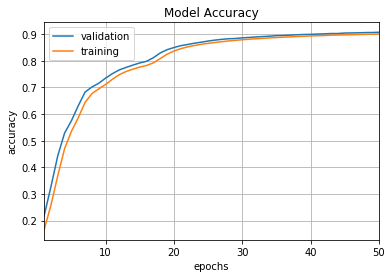

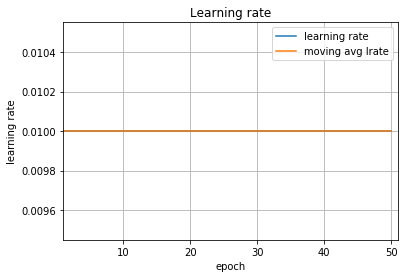

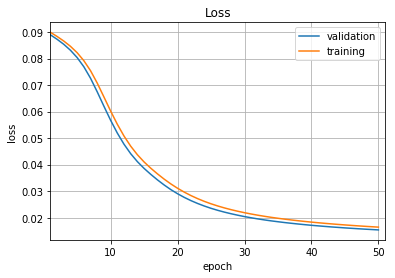

============sgd/step_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.25
avg lr: 0.458333333333
epoch complete
lr: 0.25
avg lr: 0.428571428571
epoch complete
lr: 0.25
avg lr: 0.40625
epoch complete
lr: 0.25
avg lr: 0.388888888889
epoch complete
lr: 0.25
avg lr: 0.375
epoch complete
lr: 0.125
avg lr: 0.352272727273
epoch complete
lr: 0.125
avg 

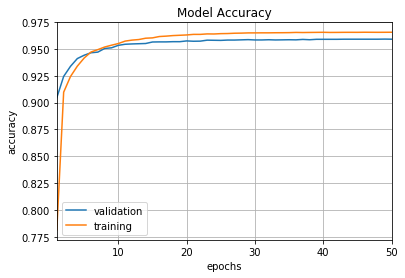

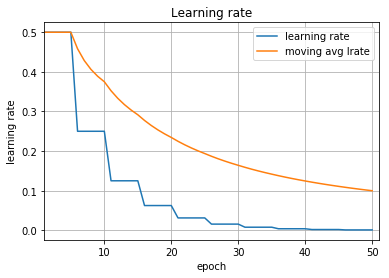

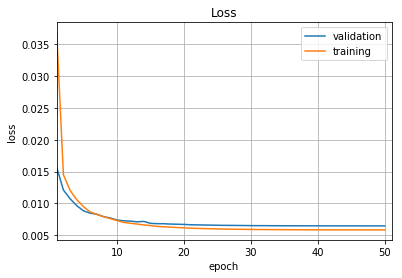

============sgd/time_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.49
avg lr: 0.495000004768
epoch complete
lr: 0.48
avg lr: 0.489999999603
epoch complete
lr: 0.47
avg lr: 0.484999999404
epoch complete
lr: 0.46
avg lr: 0.480000001192
epoch complete
lr: 0.45
avg lr: 0.474999999007
epoch complete
lr: 0.44
avg lr: 0.469999998808
epoch complete
lr: 0.43
avg lr: 0.464999999851
epoch complete
lr: 0.42
avg lr: 0.459999998411
epoch complete
lr: 0.41
avg lr: 0.454999998212
epoch complet

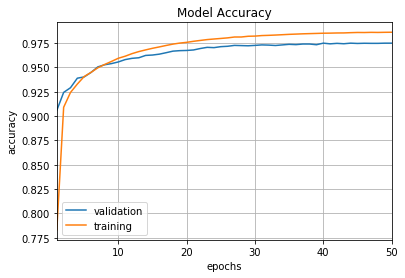

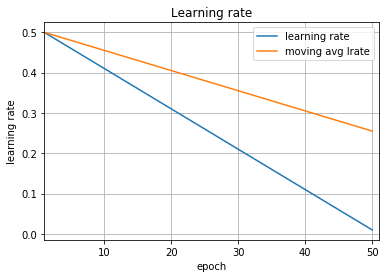

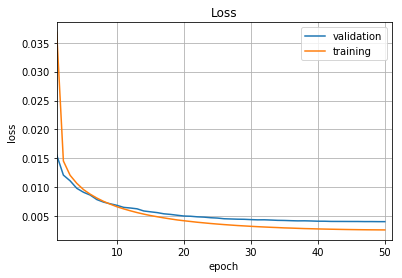

============sgd/exp_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.452419
avg lr: 0.476209357381
epoch complete
lr: 0.409365
avg lr: 0.453928033511
epoch complete
lr: 0.370409
avg lr: 0.433048300445
epoch complete
lr: 0.33516
avg lr: 0.413470643759
epoch complete
lr: 0.303265
avg lr: 0.395103091995
epoch complete
lr: 0.274406
avg lr: 0.377860622747
epoch complete
lr: 0.248293
avg lr: 0.361664626747
epoch complete
lr: 0.224664
avg lr: 0.346442388164
epoch complete
lr: 0.203285
av

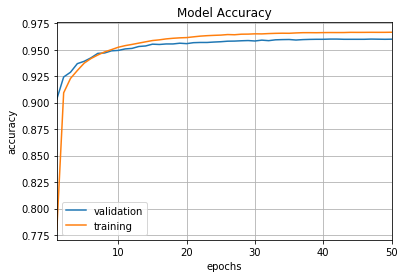

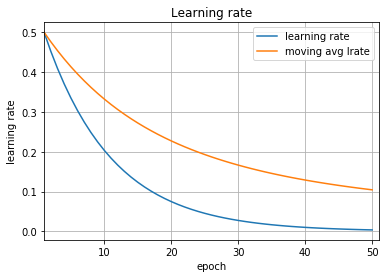

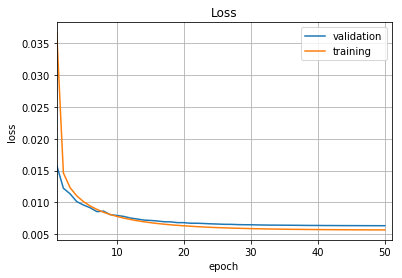

============sgd/uni_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.477524
avg lr: 0.477524131536
epoch complete
lr: 0.913663
avg lr: 0.695593550801
epoch complete
lr: 0.408341
avg lr: 0.599842687448
epoch complete
lr: 0.16161
avg lr: 0.490284528583
epoch complete
lr: 0.708699
avg lr: 0.533967337012
epoch complete
lr: 0.444044
avg lr: 0.518980053564
epoch complete
lr: 0.944479
avg lr: 0.579765573144
epoch complete
lr: 0.205231
avg lr: 0.532948711887
epoch complete
lr: 0.139417
avg lr: 0.489222912325
epoch complete

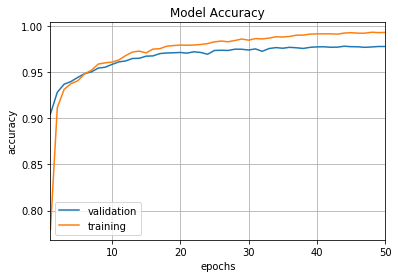

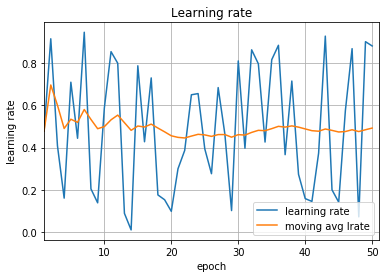

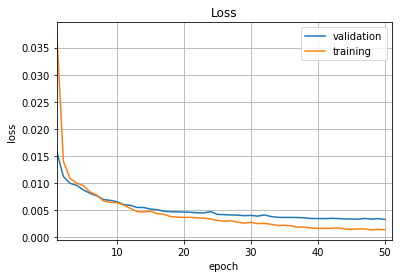

============sgd/tri_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.442409
avg lr: 0.442409187555
epoch complete
lr: 0.233104
avg lr: 0.337756663561
epoch complete
lr: 0.552296
avg lr: 0.409269849459
epoch complete
lr: 0.291191
avg lr: 0.379750065506
epoch complete
lr: 0.887623
avg lr: 0.48132455945
epoch complete
lr: 0.856627
avg lr: 0.543874914447
epoch complete
lr: 0.460853
avg lr: 0.532014591353
epoch complete
lr: 0.468795
avg lr: 0.524112146348
epoch complete
lr: 0.631414
avg lr: 0.536034627093
epoch complete

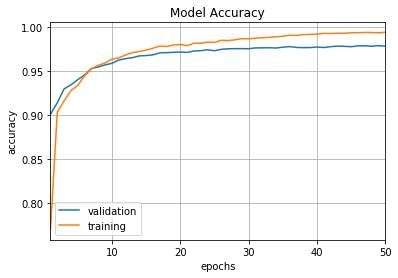

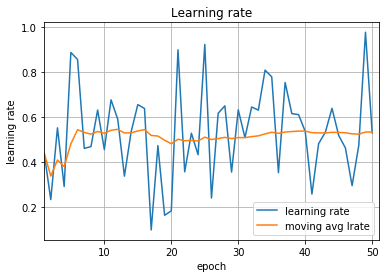

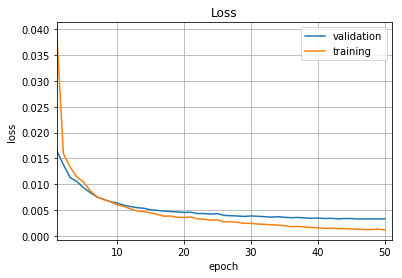

============sgd/norm_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.519299
avg lr: 0.519298553467
epoch complete
lr: 0.300383
avg lr: 0.40984095633
epoch complete
lr: 0.775877
avg lr: 0.53185287118
epoch complete
lr: 1.19652
avg lr: 0.698019526899
epoch complete
lr: 0.350442
avg lr: 0.628504025936
epoch complete
lr: 0.374311
avg lr: 0.586138571302
epoch complete
lr: 1.99438
avg lr: 0.787316479853
epoch complete
lr: 0.422266
avg lr: 0.741685178131
epoch complete
lr: 0.416483
avg lr: 0.705551640855
epoch complete
l

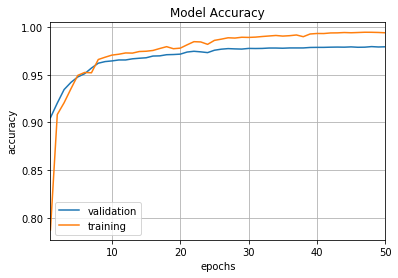

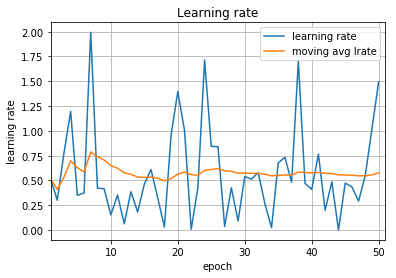

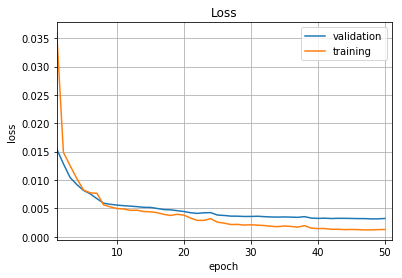

============sgd/beta_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.155749
avg lr: 0.155748546124
epoch complete
lr: 0.307328
avg lr: 0.231538251042
epoch complete
lr: 0.152587
avg lr: 0.205221111576
epoch complete
lr: 0.569671
avg lr: 0.296333592385
epoch complete
lr: 0.53559
avg lr: 0.344184932113
epoch complete
lr: 0.818391
avg lr: 0.4232192114
epoch complete
lr: 0.976357
avg lr: 0.502238850508
epoch complete
lr: 0.631945
avg lr: 0.518452091143
epoch complete
lr: 0.774455
avg lr: 0.546896866626
epoch complete


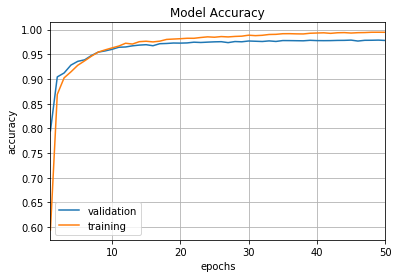

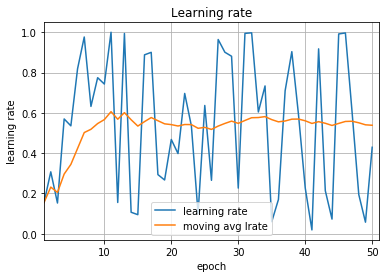

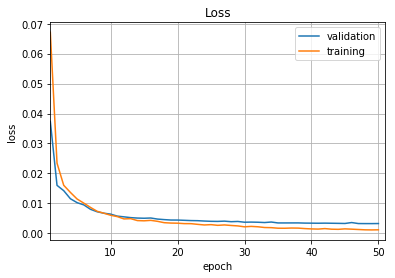

%%%%%%%%%%%rms%%%%%%%%%%%%%%
============rms/constant=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epo

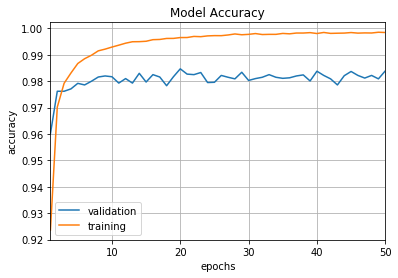

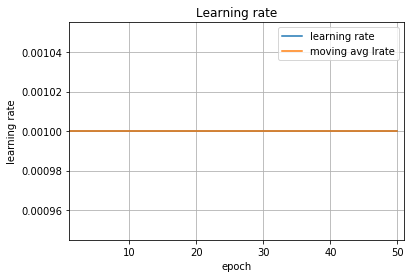

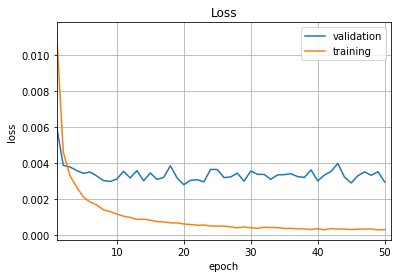

============rms/step_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.25
avg lr: 0.458333333333
epoch complete
lr: 0.25
avg lr: 0.428571428571
epoch complete
lr: 0.25
avg lr: 0.40625
epoch complete
lr: 0.25
avg lr: 0.388888888889
epoch complete
lr: 0.25
avg lr: 0.375
epoch complete
lr: 0.125
avg lr: 0.352272727273
epoch complete
lr: 0.125
avg 

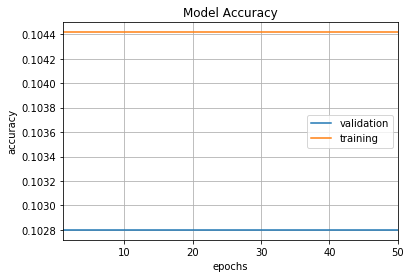

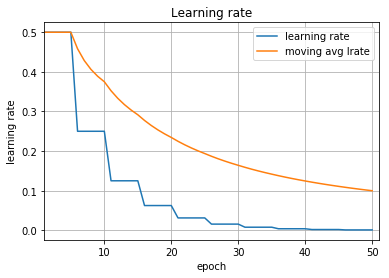

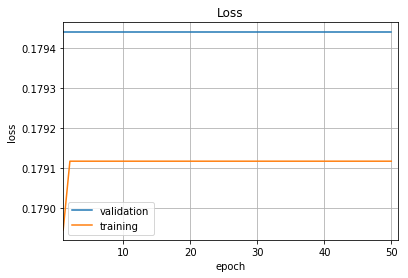

============rms/time_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.49
avg lr: 0.495000004768
epoch complete
lr: 0.48
avg lr: 0.489999999603
epoch complete
lr: 0.47
avg lr: 0.484999999404
epoch complete
lr: 0.46
avg lr: 0.480000001192
epoch complete
lr: 0.45
avg lr: 0.474999999007
epoch complete
lr: 0.44
avg lr: 0.469999998808
epoch complete
lr: 0.43
avg lr: 0.464999999851
epoch complete
lr: 0.42
avg lr: 0.459999998411
epoch complete
lr: 0.41
avg lr: 0.454999998212
epoch complet

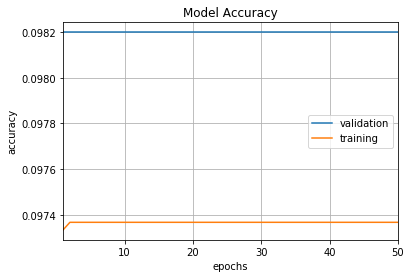

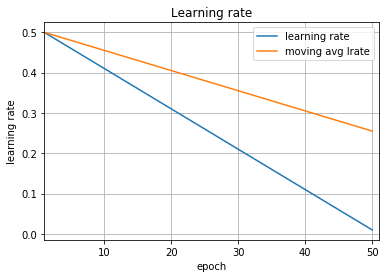

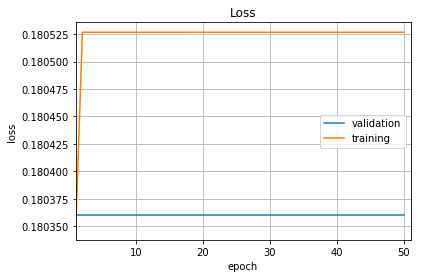

============rms/exp_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.452419
avg lr: 0.476209357381
epoch complete
lr: 0.409365
avg lr: 0.453928033511
epoch complete
lr: 0.370409
avg lr: 0.433048300445
epoch complete
lr: 0.33516
avg lr: 0.413470643759
epoch complete
lr: 0.303265
avg lr: 0.395103091995
epoch complete
lr: 0.274406
avg lr: 0.377860622747
epoch complete
lr: 0.248293
avg lr: 0.361664626747
epoch complete
lr: 0.224664
avg lr: 0.346442388164
epoch complete
lr: 0.203285
av

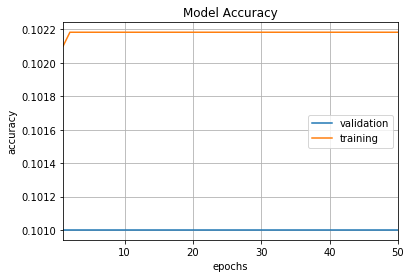

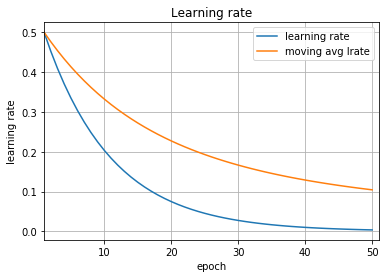

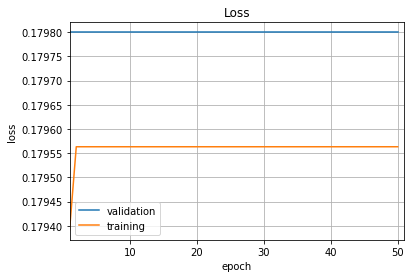

============rms/uni_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.119197
avg lr: 0.119197241962
epoch complete
lr: 0.66751
avg lr: 0.393353398889
epoch complete
lr: 0.807258
avg lr: 0.531321741641
epoch complete
lr: 0.939986
avg lr: 0.633487818763
epoch complete
lr: 0.64783
avg lr: 0.63635623306
epoch complete
lr: 0.607423
avg lr: 0.631534098337
epoch complete
lr: 0.962356
avg lr: 0.678794340364
epoch complete
lr: 0.423977
avg lr: 0.646942152642
epoch complete
lr: 0.722919
avg lr: 0.655384003288
epoch complete
l

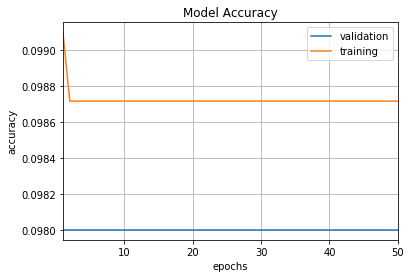

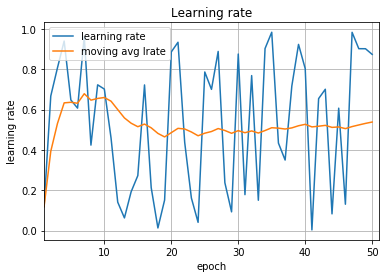

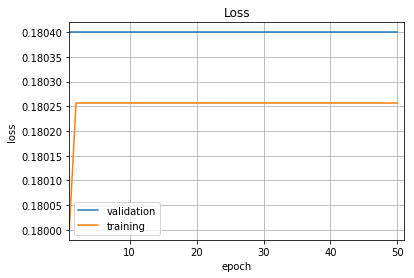

============rms/tri_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.580314
avg lr: 0.580313622952
epoch complete
lr: 0.223521
avg lr: 0.401917308569
epoch complete
lr: 0.452063
avg lr: 0.418632407983
epoch complete
lr: 0.673235
avg lr: 0.482283011079
epoch complete
lr: 0.722568
avg lr: 0.530340051651
epoch complete
lr: 0.0917829
avg lr: 0.457247196386
epoch complete
lr: 0.303462
avg lr: 0.435277831342
epoch complete
lr: 0.425171
avg lr: 0.434014420025
epoch complete
lr: 0.670619
avg lr: 0.460303865373
epoch comple

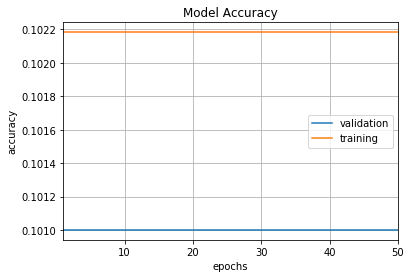

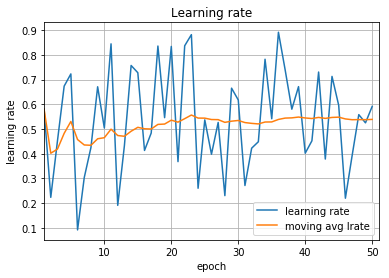

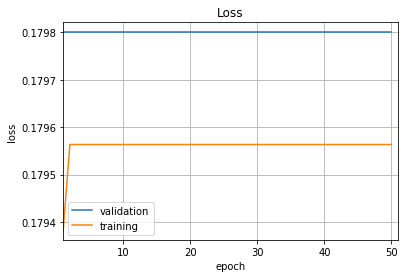

============rms/norm_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 1.87155
avg lr: 1.87154877186
epoch complete
lr: 0.964341
avg lr: 1.41794493794
epoch complete
lr: 0.222953
avg lr: 1.01961433391
epoch complete
lr: 1.72374
avg lr: 1.19564622268
epoch complete
lr: 0.984658
avg lr: 1.15344860256
epoch complete
lr: 1.06403
avg lr: 1.13854562988
epoch complete
lr: 0.896994
avg lr: 1.10403830452
epoch complete
lr: 0.519552
avg lr: 1.0309774857
epoch complete
lr: 0.60634
avg lr: 0.983795521988
epoch complete
lr: 1.6038

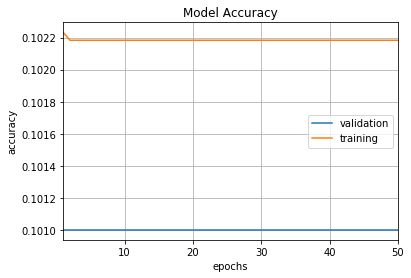

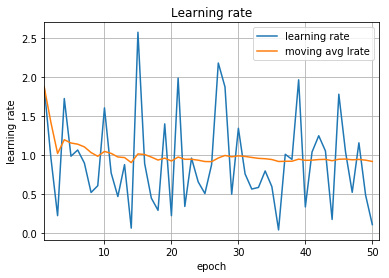

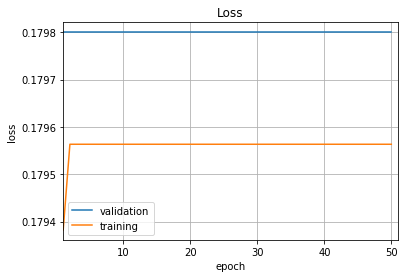

============rms/beta_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.856002
avg lr: 0.856002032757
epoch complete
lr: 0.379333
avg lr: 0.617667347193
epoch complete
lr: 0.00240644
avg lr: 0.412580379363
epoch complete
lr: 0.40067
avg lr: 0.409602760163
epoch complete
lr: 0.991135
avg lr: 0.525909148762
epoch complete
lr: 0.986013
avg lr: 0.602593123176
epoch complete
lr: 0.856831
avg lr: 0.638912787827
epoch complete
lr: 0.0262728
avg lr: 0.562332785601
epoch complete
lr: 0.0761724
avg lr: 0.508314967078
epoch com

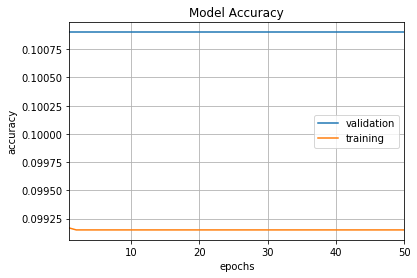

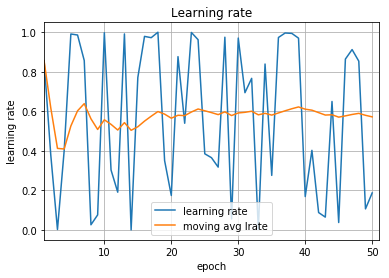

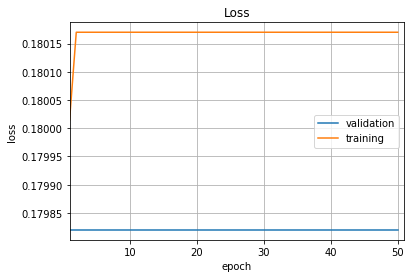

%%%%%%%%%%%adam%%%%%%%%%%%%%%
============adam/constant=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
e

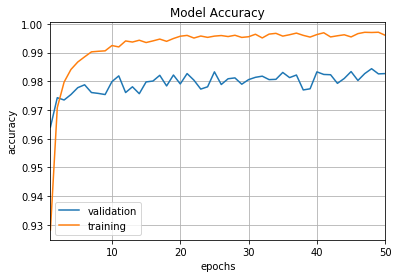

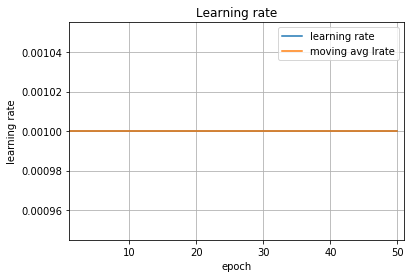

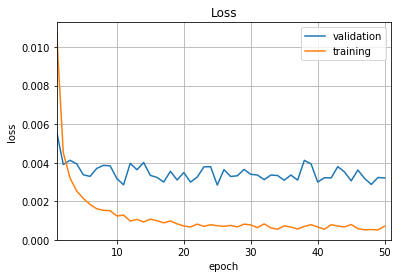

============adam/step_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.25
avg lr: 0.458333333333
epoch complete
lr: 0.25
avg lr: 0.428571428571
epoch complete
lr: 0.25
avg lr: 0.40625
epoch complete
lr: 0.25
avg lr: 0.388888888889
epoch complete
lr: 0.25
avg lr: 0.375
epoch complete
lr: 0.125
avg lr: 0.352272727273
epoch complete
lr: 0.125
avg

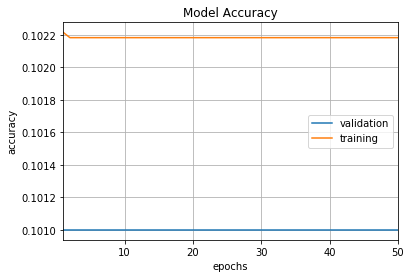

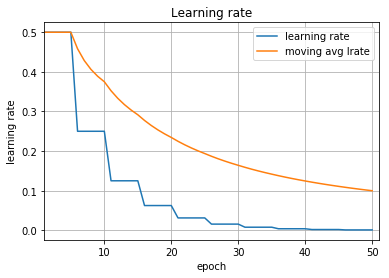

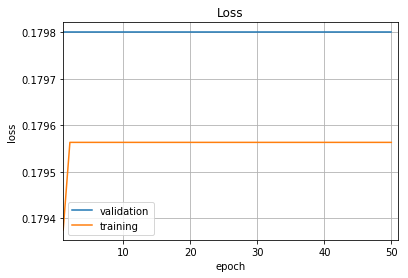

============adam/time_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.49
avg lr: 0.495000004768
epoch complete
lr: 0.48
avg lr: 0.489999999603
epoch complete
lr: 0.47
avg lr: 0.484999999404
epoch complete
lr: 0.46
avg lr: 0.480000001192
epoch complete
lr: 0.45
avg lr: 0.474999999007
epoch complete
lr: 0.44
avg lr: 0.469999998808
epoch complete
lr: 0.43
avg lr: 0.464999999851
epoch complete
lr: 0.42
avg lr: 0.459999998411
epoch complete
lr: 0.41
avg lr: 0.454999998212
epoch comple

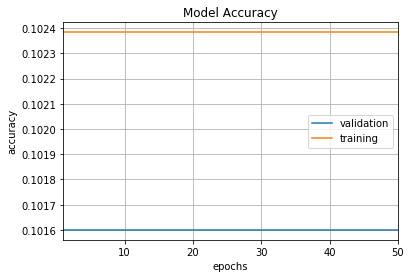

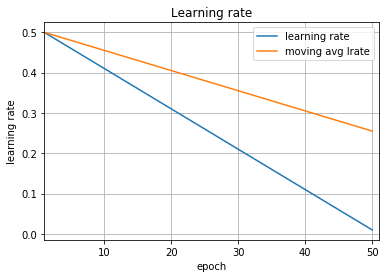

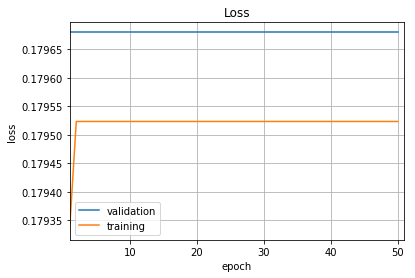

============adam/exp_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.452419
avg lr: 0.476209357381
epoch complete
lr: 0.409365
avg lr: 0.453928033511
epoch complete
lr: 0.370409
avg lr: 0.433048300445
epoch complete
lr: 0.33516
avg lr: 0.413470643759
epoch complete
lr: 0.303265
avg lr: 0.395103091995
epoch complete
lr: 0.274406
avg lr: 0.377860622747
epoch complete
lr: 0.248293
avg lr: 0.361664626747
epoch complete
lr: 0.224664
avg lr: 0.346442388164
epoch complete
lr: 0.203285
a

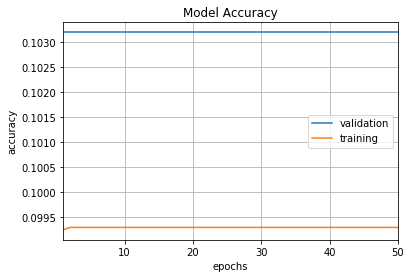

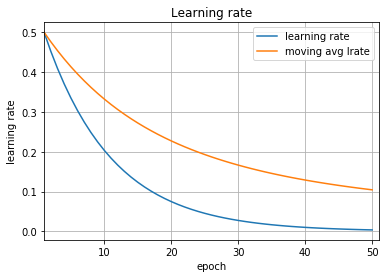

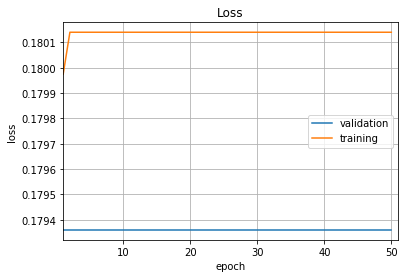

============adam/uni_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.473583
avg lr: 0.473582953215
epoch complete
lr: 0.30154
avg lr: 0.387561693788
epoch complete
lr: 0.0975102
avg lr: 0.290877868732
epoch complete
lr: 0.212602
avg lr: 0.27130895108
epoch complete
lr: 0.688994
avg lr: 0.354845923185
epoch complete
lr: 0.779214
avg lr: 0.425573900342
epoch complete
lr: 0.786272
avg lr: 0.477102224316
epoch complete
lr: 0.166718
avg lr: 0.438304219395
epoch complete
lr: 0.656151
avg lr: 0.462509410249
epoch complet

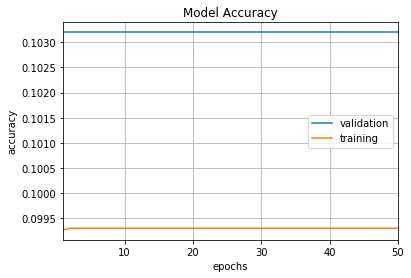

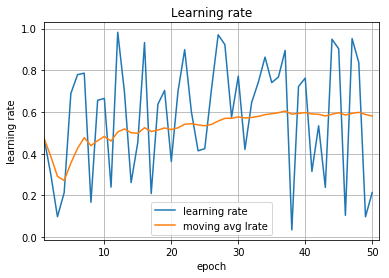

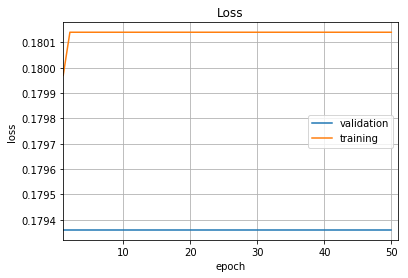

============adam/tri_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.24597
avg lr: 0.245969757438
epoch complete
lr: 0.222217
avg lr: 0.234093405306
epoch complete
lr: 0.548706
avg lr: 0.338964427511
epoch complete
lr: 0.659587
avg lr: 0.419120166451
epoch complete
lr: 0.679639
avg lr: 0.471223893762
epoch complete
lr: 0.67082
avg lr: 0.504489950836
epoch complete
lr: 0.673065
avg lr: 0.528572067618
epoch complete
lr: 0.39195
avg lr: 0.511494265869
epoch complete
lr: 0.423562
avg lr: 0.501724042826
epoch complete


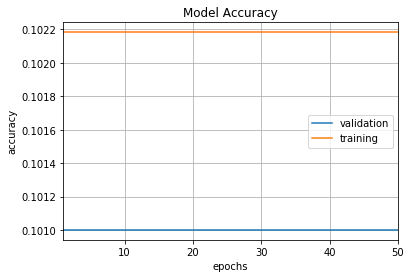

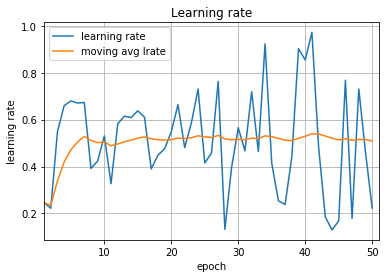

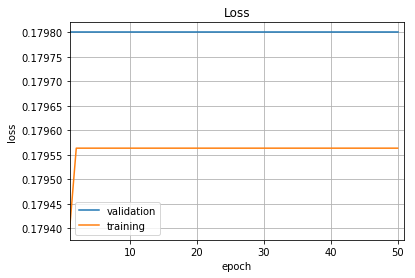

============adam/norm_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.188138
avg lr: 0.188137680292
epoch complete
lr: 0.712389
avg lr: 0.450263306499
epoch complete
lr: 1.32622
avg lr: 0.742249161005
epoch complete
lr: 0.922881
avg lr: 0.787407003343
epoch complete
lr: 0.0463951
avg lr: 0.639204630256
epoch complete
lr: 0.0351139
avg lr: 0.538522838925
epoch complete
lr: 0.0370411
avg lr: 0.466882588076
epoch complete
lr: 0.657459
avg lr: 0.490704612341
epoch complete
lr: 2.27876
avg lr: 0.689377640271
epoch comp

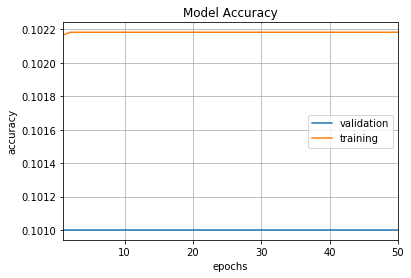

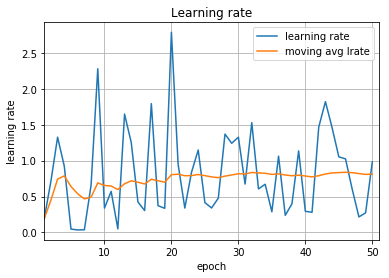

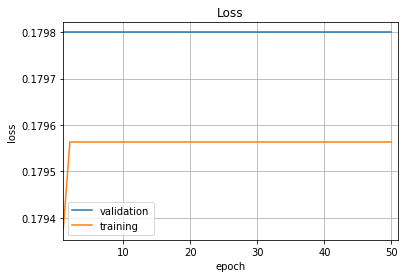

============adam/beta_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.120397
avg lr: 0.12039680779
epoch complete
lr: 0.0034676
avg lr: 0.0619322055718
epoch complete
lr: 0.833946
avg lr: 0.319270093848
epoch complete
lr: 0.0232873
avg lr: 0.24527439446
epoch complete
lr: 0.0236597
avg lr: 0.200951448223
epoch complete
lr: 0.839774
avg lr: 0.307421845811
epoch complete
lr: 0.0754058
avg lr: 0.27427669731
epoch complete
lr: 0.0836914
avg lr: 0.250453531829
epoch complete
lr: 0.971781
avg lr: 0.330601082985
epoch co

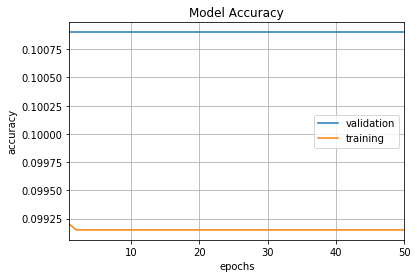

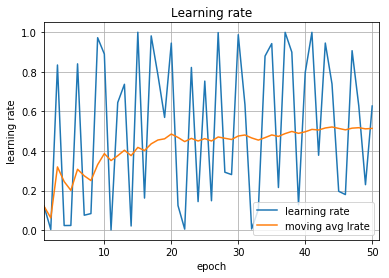

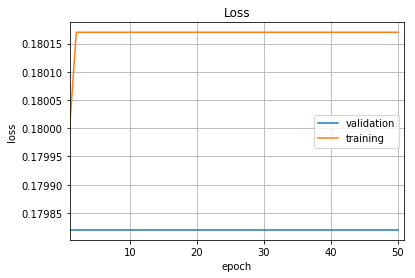

%%%%%%%%%%%adag%%%%%%%%%%%%%%
============adag/constant=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
epoch complete
lr: 0.01
avg lr: 0.00999999977648
e

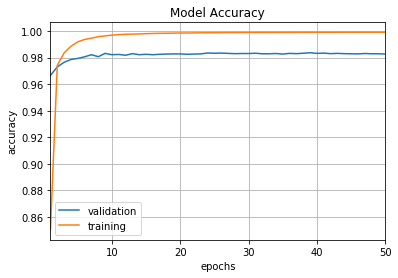

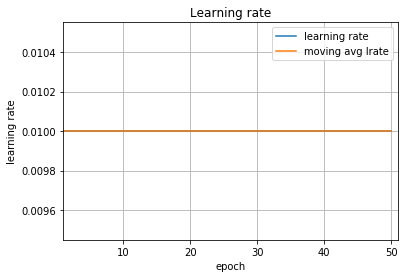

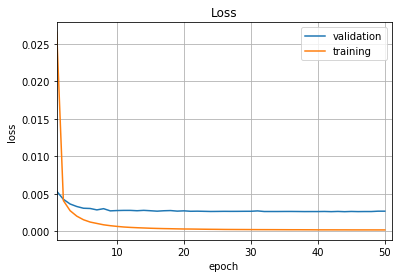

============adag/step_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.25
avg lr: 0.458333333333
epoch complete
lr: 0.25
avg lr: 0.428571428571
epoch complete
lr: 0.25
avg lr: 0.40625
epoch complete
lr: 0.25
avg lr: 0.388888888889
epoch complete
lr: 0.25
avg lr: 0.375
epoch complete
lr: 0.125
avg lr: 0.352272727273
epoch complete
lr: 0.125
avg

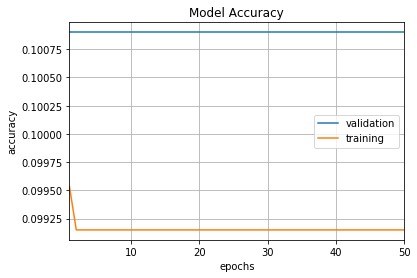

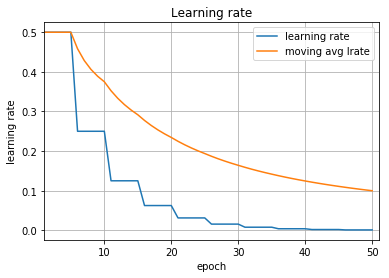

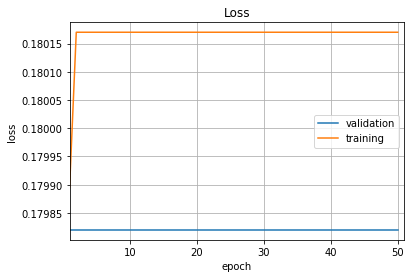

============adag/time_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.49
avg lr: 0.495000004768
epoch complete
lr: 0.48
avg lr: 0.489999999603
epoch complete
lr: 0.47
avg lr: 0.484999999404
epoch complete
lr: 0.46
avg lr: 0.480000001192
epoch complete
lr: 0.45
avg lr: 0.474999999007
epoch complete
lr: 0.44
avg lr: 0.469999998808
epoch complete
lr: 0.43
avg lr: 0.464999999851
epoch complete
lr: 0.42
avg lr: 0.459999998411
epoch complete
lr: 0.41
avg lr: 0.454999998212
epoch comple

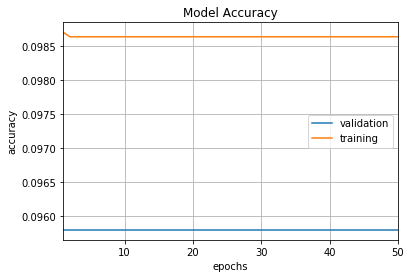

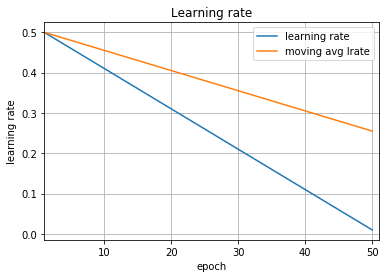

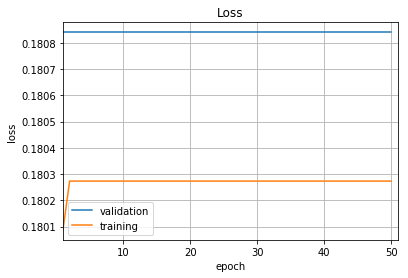

============adag/exp_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.452419
avg lr: 0.476209357381
epoch complete
lr: 0.409365
avg lr: 0.453928033511
epoch complete
lr: 0.370409
avg lr: 0.433048300445
epoch complete
lr: 0.33516
avg lr: 0.413470643759
epoch complete
lr: 0.303265
avg lr: 0.395103091995
epoch complete
lr: 0.274406
avg lr: 0.377860622747
epoch complete
lr: 0.248293
avg lr: 0.361664626747
epoch complete
lr: 0.224664
avg lr: 0.346442388164
epoch complete
lr: 0.203285
a

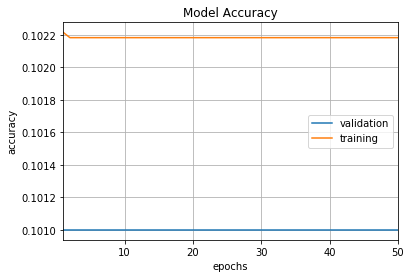

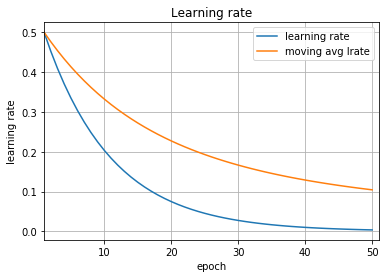

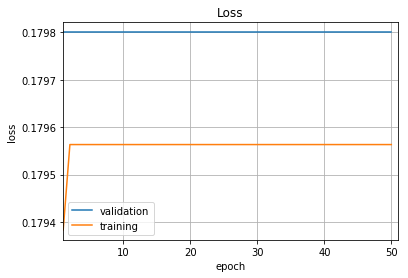

============adag/uni_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.196499
avg lr: 0.196498885751
epoch complete
lr: 0.501089
avg lr: 0.348793782294
epoch complete
lr: 0.0672885
avg lr: 0.254958704114
epoch complete
lr: 0.145652
avg lr: 0.227632064372
epoch complete
lr: 0.885016
avg lr: 0.359108892083
epoch complete
lr: 0.23319
avg lr: 0.338122412562
epoch complete
lr: 0.59838
avg lr: 0.375302072082
epoch complete
lr: 0.637276
avg lr: 0.408048797399
epoch complete
lr: 0.778157
avg lr: 0.449171976911
epoch complet

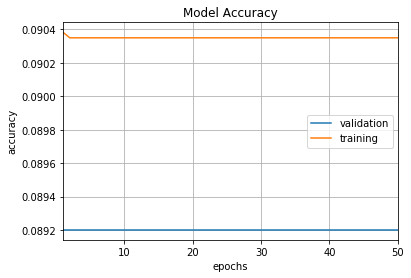

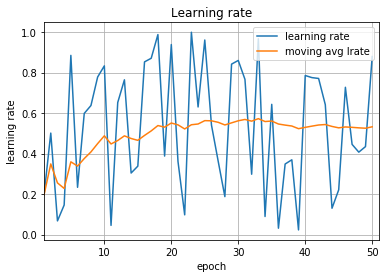

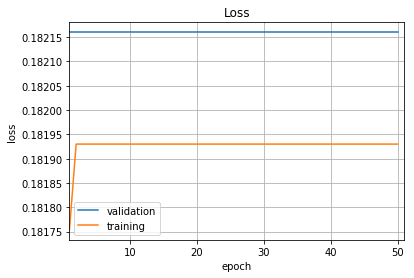

============adag/tri_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.580314
avg lr: 0.580313742161
epoch complete
lr: 0.338099
avg lr: 0.459206432104
epoch complete
lr: 0.315703
avg lr: 0.411371966203
epoch complete
lr: 0.2817
avg lr: 0.378953948617
epoch complete
lr: 0.666134
avg lr: 0.436390006542
epoch complete
lr: 0.283879
avg lr: 0.410971497496
epoch complete
lr: 0.327076
avg lr: 0.398986492838
epoch complete
lr: 0.40474
avg lr: 0.399705633521
epoch complete
lr: 0.0808556
avg lr: 0.364277852078
epoch complete

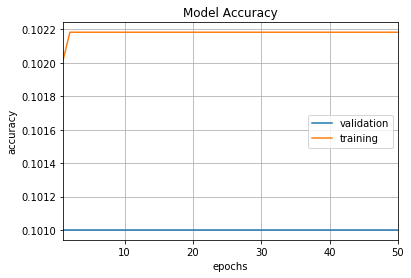

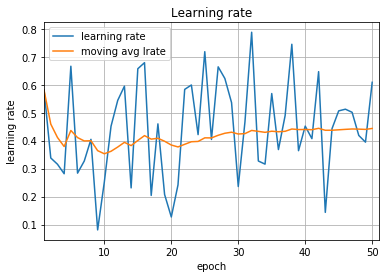

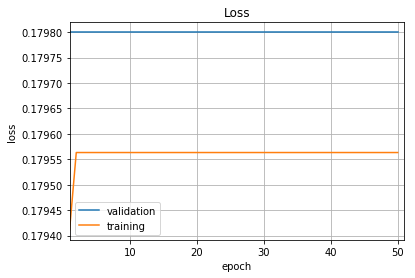

============adag/norm_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 1.00911
avg lr: 1.00911188126
epoch complete
lr: 0.117222
avg lr: 0.563166841865
epoch complete
lr: 0.229942
avg lr: 0.452091957132
epoch complete
lr: 3.1187
avg lr: 1.11874397472
epoch complete
lr: 0.948478
avg lr: 1.08469070494
epoch complete
lr: 0.751594
avg lr: 1.02917466809
epoch complete
lr: 1.67036
avg lr: 1.12077204032
epoch complete
lr: 0.539792
avg lr: 1.04814949818
epoch complete
lr: 0.660735
avg lr: 1.00510345068
epoch complete
lr: 1.1

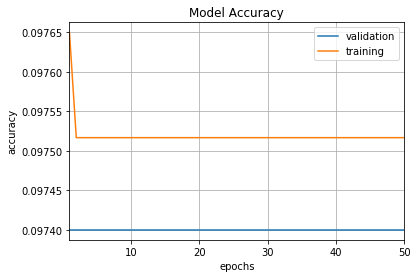

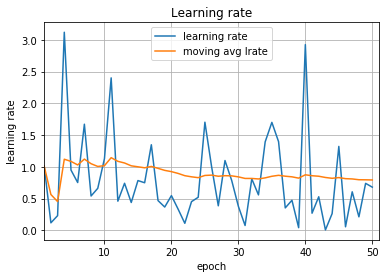

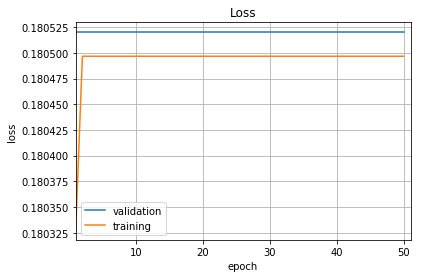

============adag/beta_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.158027
avg lr: 0.158027350903
epoch complete
lr: 0.237134
avg lr: 0.197580762208
epoch complete
lr: 0.325892
avg lr: 0.240351125598
epoch complete
lr: 0.938253
avg lr: 0.414826530963
epoch complete
lr: 0.0183223
avg lr: 0.335525682941
epoch complete
lr: 0.59958
avg lr: 0.379534694366
epoch complete
lr: 0.000737287
avg lr: 0.325420779068
epoch complete
lr: 0.892377
avg lr: 0.396290316501
epoch complete
lr: 0.966556
avg lr: 0.459653165004
epoch co

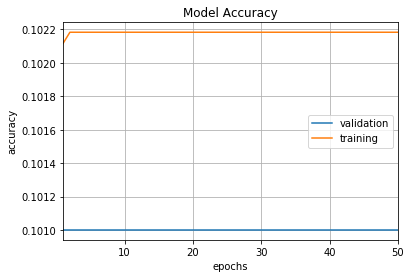

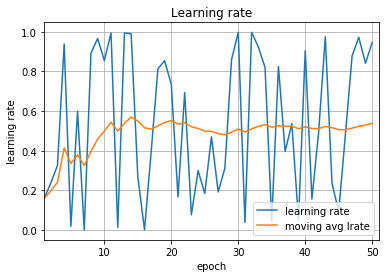

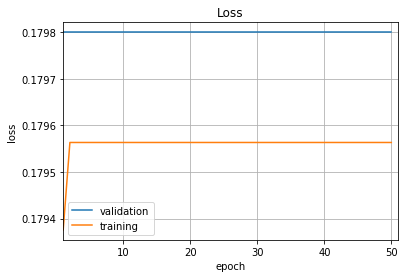

%%%%%%%%%%%adad%%%%%%%%%%%%%%
============adad/constant=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0
avg lr: 1.0
epoch complete
lr: 1.0

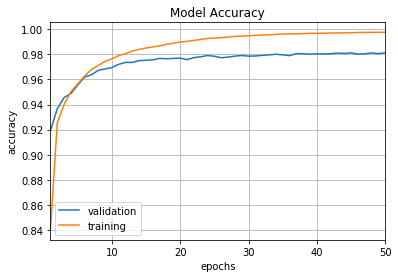

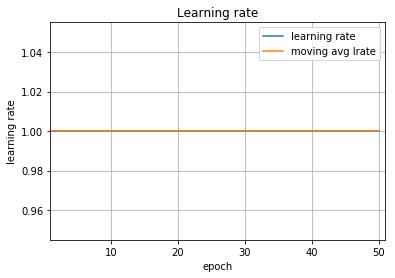

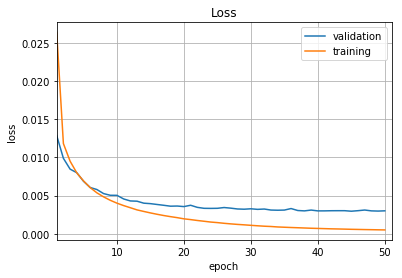

============adad/step_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.25
avg lr: 0.458333333333
epoch complete
lr: 0.25
avg lr: 0.428571428571
epoch complete
lr: 0.25
avg lr: 0.40625
epoch complete
lr: 0.25
avg lr: 0.388888888889
epoch complete
lr: 0.25
avg lr: 0.375
epoch complete
lr: 0.125
avg lr: 0.352272727273
epoch complete
lr: 0.125
avg

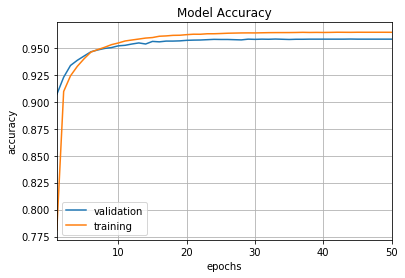

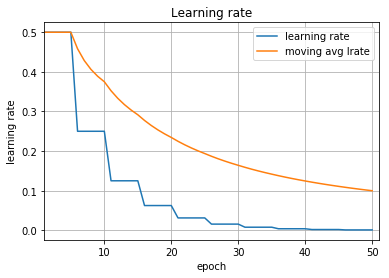

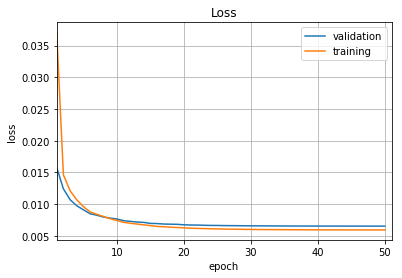

============adad/time_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.49
avg lr: 0.495000004768
epoch complete
lr: 0.48
avg lr: 0.489999999603
epoch complete
lr: 0.47
avg lr: 0.484999999404
epoch complete
lr: 0.46
avg lr: 0.480000001192
epoch complete
lr: 0.45
avg lr: 0.474999999007
epoch complete
lr: 0.44
avg lr: 0.469999998808
epoch complete
lr: 0.43
avg lr: 0.464999999851
epoch complete
lr: 0.42
avg lr: 0.459999998411
epoch complete
lr: 0.41
avg lr: 0.454999998212
epoch comple

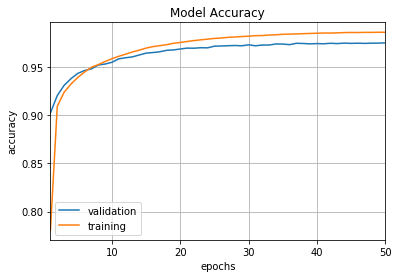

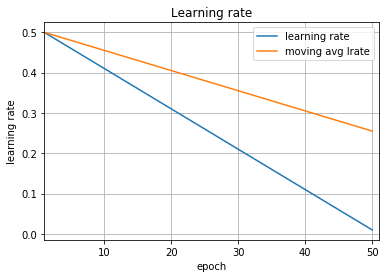

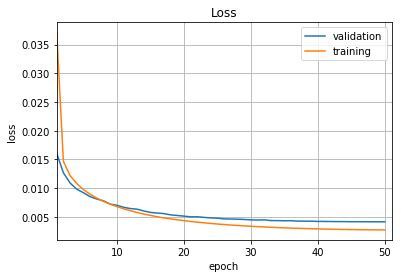

============adad/exp_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.5
avg lr: 0.5
epoch complete
lr: 0.452419
avg lr: 0.476209357381
epoch complete
lr: 0.409365
avg lr: 0.453928033511
epoch complete
lr: 0.370409
avg lr: 0.433048300445
epoch complete
lr: 0.33516
avg lr: 0.413470643759
epoch complete
lr: 0.303265
avg lr: 0.395103091995
epoch complete
lr: 0.274406
avg lr: 0.377860622747
epoch complete
lr: 0.248293
avg lr: 0.361664626747
epoch complete
lr: 0.224664
avg lr: 0.346442388164
epoch complete
lr: 0.203285
a

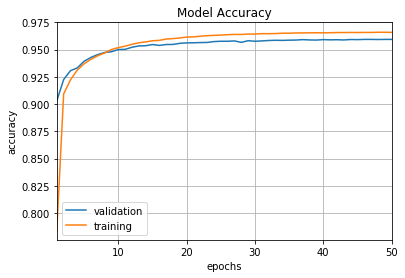

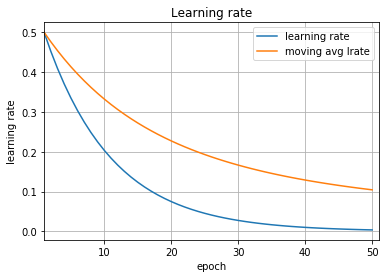

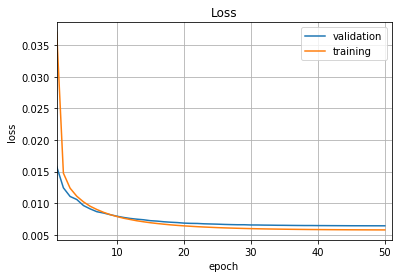

============adad/uni_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.304426
avg lr: 0.304425746202
epoch complete
lr: 0.0877386
avg lr: 0.19608219713
epoch complete
lr: 0.213073
avg lr: 0.201745698849
epoch complete
lr: 0.423015
avg lr: 0.257063113153
epoch complete
lr: 0.979672
avg lr: 0.401584917307
epoch complete
lr: 0.4877
avg lr: 0.415937398871
epoch complete
lr: 0.454494
avg lr: 0.42144543784
epoch complete
lr: 0.753175
avg lr: 0.462911687791
epoch complete
lr: 0.689279
avg lr: 0.488063560592
epoch complete


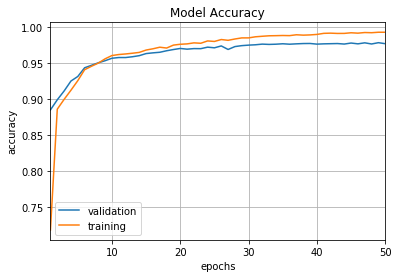

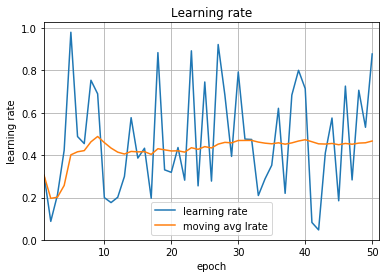

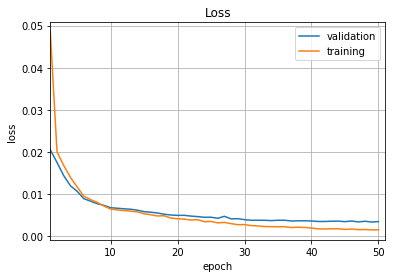

============adad/tri_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.477819
avg lr: 0.477819472551
epoch complete
lr: 0.72498
avg lr: 0.601399883628
epoch complete
lr: 0.379011
avg lr: 0.527270297209
epoch complete
lr: 0.819562
avg lr: 0.600343286991
epoch complete
lr: 0.506153
avg lr: 0.581505262852
epoch complete
lr: 0.737635
avg lr: 0.607526868582
epoch complete
lr: 0.6099
avg lr: 0.607865895544
epoch complete
lr: 0.168916
avg lr: 0.552997207269
epoch complete
lr: 0.507774
avg lr: 0.547972425818
epoch complete


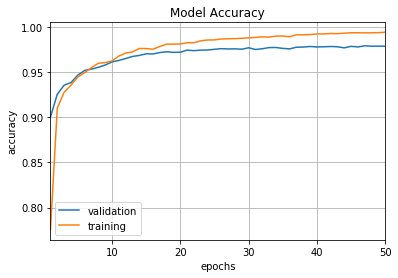

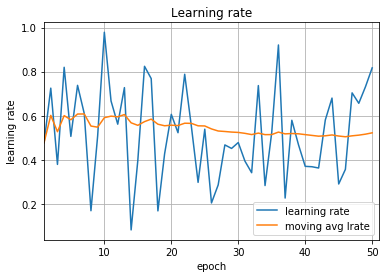

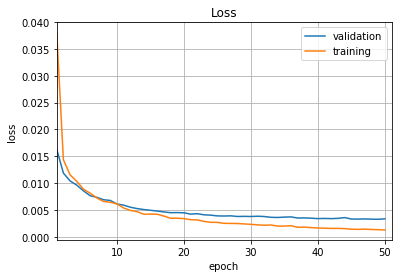

============adad/norm_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.337961
avg lr: 0.337961018085
epoch complete
lr: 0.600536
avg lr: 0.469248622656
epoch complete
lr: 0.259466
avg lr: 0.399320930243
epoch complete
lr: 0.804886
avg lr: 0.500712074339
epoch complete
lr: 0.179973
avg lr: 0.436564314365
epoch complete
lr: 0.572478
avg lr: 0.459216574828
epoch complete
lr: 1.06757
avg lr: 0.546124100685
epoch complete
lr: 0.338658
avg lr: 0.520190782845
epoch complete
lr: 0.795164
avg lr: 0.550743334823
epoch comple

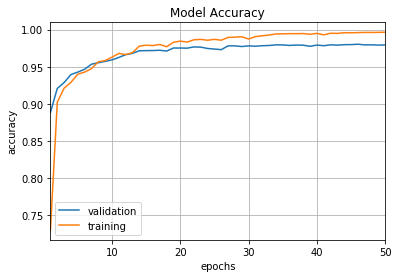

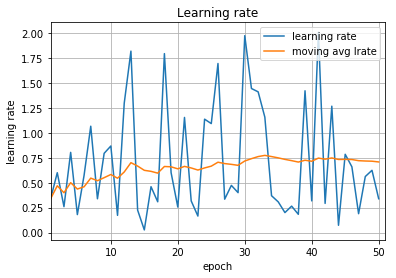

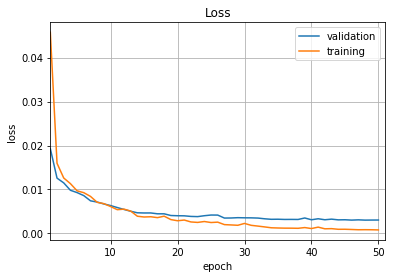

============adad/beta_decay=================
[[ 0.04045932  0.03014778 -0.05395085 ..., -0.0265603  -0.06797015
   0.04132435]
 [ 0.0323295  -0.06156345  0.04380944 ..., -0.0513295   0.01277255
   0.05407738]
 [ 0.03364889  0.04805643  0.02008962 ...,  0.03593016 -0.04270403
   0.06212938]
 ..., 
 [ 0.04504235  0.06577076 -0.04492702 ..., -0.01310821 -0.05994209
  -0.03663909]
 [ 0.00522865 -0.06398395  0.01149733 ...,  0.02461017 -0.03791013
   0.04420398]
 [-0.01271584 -0.0538175   0.06545508 ..., -0.01888941 -0.00182088
   0.0624886 ]]
lr: 0.988007
avg lr: 0.988007426262
epoch complete
lr: 0.00125511
avg lr: 0.494631265814
epoch complete
lr: 0.6543
avg lr: 0.547854248163
epoch complete
lr: 0.350217
avg lr: 0.498444999364
epoch complete
lr: 0.525863
avg lr: 0.503928657458
epoch complete
lr: 0.985026
avg lr: 0.584111617742
epoch complete
lr: 0.629
avg lr: 0.590524253452
epoch complete
lr: 0.794587
avg lr: 0.616032039179
epoch complete
lr: 0.545764
avg lr: 0.608224475873
epoch complete

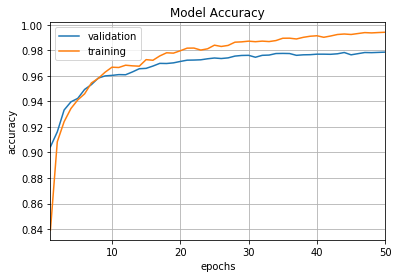

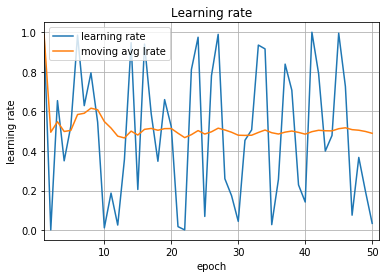

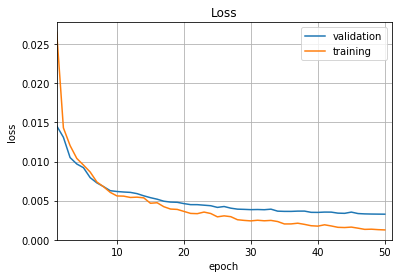

In [69]:
batch_size = 128
num_classes = 10
epochs = 50

# learning schedule callback
lrate_history = LossHistory()

#
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adag = keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
adad = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

optimizer_list = [sgd,rms, adam, adag, adad]
schedules_list = [constant,step_decay, time_decay, exp_decay,
                  uni_decay, tri_decay, norm_decay, beta_decay]
schedules_str_list = ['constant','step_decay','time_decay','exp_decay',
                      'uni_decay', 'tri_decay', 'norm_decay', 'beta_decay']
optimizer_str_list = ['sgd', 'rms', 'adam', 'adag', 'adad']
idx_opt = 0
for optimizer in optimizer_list:
    print('%%%%%%%%%%%'+optimizer_str_list[idx_opt]+'%%%%%%%%%%%%%%')
    idx_sch=0
    for schedule in schedules_list:
        if schedules_str_list[idx_sch] == 'constant':
            callbacks_list = [lrate_history]
        else:
            lrate = LearningRateScheduler(schedule)
            callbacks_list = [lrate_history, lrate]
        #Identify
        identity = optimizer_str_list[idx_opt]+'/'+schedules_str_list[idx_sch]
        print('============'+identity+'=================')
        #Compile Model
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
        ###Save initial Weights for consistency
        ##Toggle After first model is trained
        #model.save_weights('weights/deep_rand.h5')
        #Load Weights for consistency 
        model.load_weights('weights/deep_rand.h5')
        print(model.layers[0].get_weights()[0])
        #Train Model
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=callbacks_list,
                            verbose=0,
                            validation_data=(x_test,y_test))
        #Write data
        write(identity, history, lrate_history)
        #Plot Figures
        plot_fig(identity, history, lrate_history)

        idx_sch += 1
    idx_opt += 1


In [76]:
batch_size = 128
num_classes = 10
epochs = 50

# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)



sgd = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#Compile Model
model.compile(loss='mean_squared_error',
              optimizer=rms,
              metrics=['accuracy'])
#Save initial Weights for consistency
###NOTE TOGGLE COMMENT AFTER BATCH HAS STARTED
#model.save_weights('weights/deep_rand.h5')


identity = 'Test_rms'
#Load initial weights
model.load_weights('weights/deep_rand.h5')
#reduce callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks_list = [loss_history, reduce_lr]
#Train Model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    verbose=0,
                    validation_data=(x_test, y_test))


plot_fig(identity, history)


lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.0010000000475
epoch complete
lr: 0.001
avg lr: 0.

TypeError: plot_fig() missing 1 required positional argument: 'loss_history'

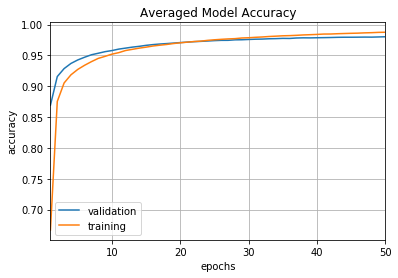

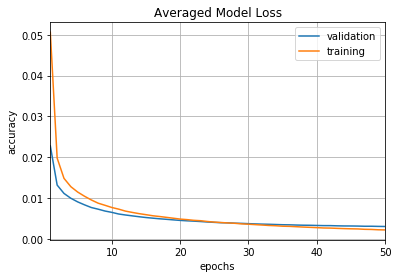

In [53]:
#calculate and plot averages
acc_total = np.zeros(50)
val_loss_total = np.zeros(50)
val_total = np.zeros(50)
loss_total = np.zeros(50)   
#import pickled history dicts
for iteration in range(10):
    filename = 'triangle/triangle_'+str(iteration)+'_'+'trainHistoryDict'
    accuracy = pickle.load(open(filename,'rb'))
    acc_total = np.add(acc_total,accuracy['acc'])
    val_total = np.add(val_total,accuracy['val_acc'])
    loss_total = np.add(loss_total,accuracy['loss'])
    val_loss_total = np.add(val_loss_total,accuracy['val_loss'])
#calculate averages
val_avg = val_total/10
acc_avg = acc_total/10
loss_avg = loss_total/10
val_loss_avg = val_loss_total/10
#Store in new history dict
uniform_averages = {'val':val_avg, 'acc':acc_avg, 'loss':loss_avg, 'val_loss':val_loss_avg}
#pickle dict for later
picklefile = open("triangle/triangle_averages.pickle","wb")
pickle.dump(uniform_averages, picklefile)
picklefile.close()



#Plot accuracies
fig = plt.figure()
plt.plot(range(1,epochs+1),uniform_averages['val'],label='validation')
plt.plot(range(1,epochs+1),uniform_averages['acc'],label='training')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim([1,epochs])

#     plt.ylim([0,1])
plt.grid(True)
plt.title("Averaged Model Accuracy")
plt.show()
fig.savefig('triangle/triangle_avg_accuracy.png')
plt.close(fig)



#Plot Losses
fig = plt.figure()
plt.plot(range(1,epochs+1),uniform_averages['val_loss'],label='validation')
plt.plot(range(1,epochs+1),uniform_averages['loss'],label='training')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xlim([1,epochs])

#     plt.ylim([0,1])
plt.grid(True)
plt.title("Averaged Model Loss")
plt.show()
fig.savefig('triangle/triangle_avg_loss.png')
plt.close(fig)

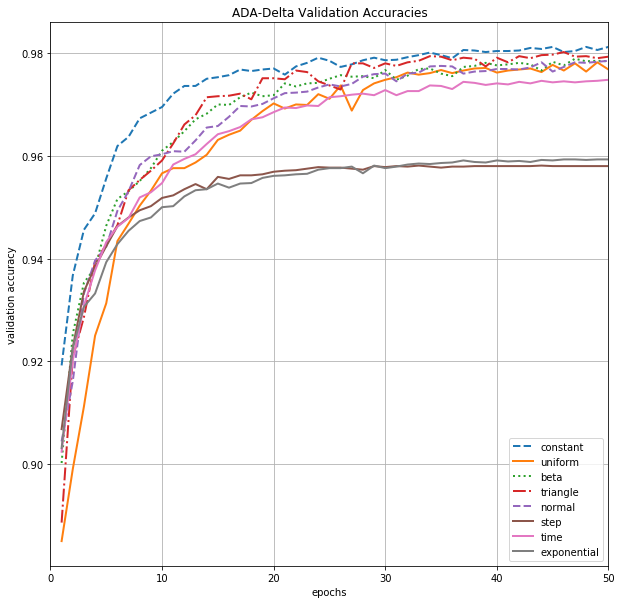

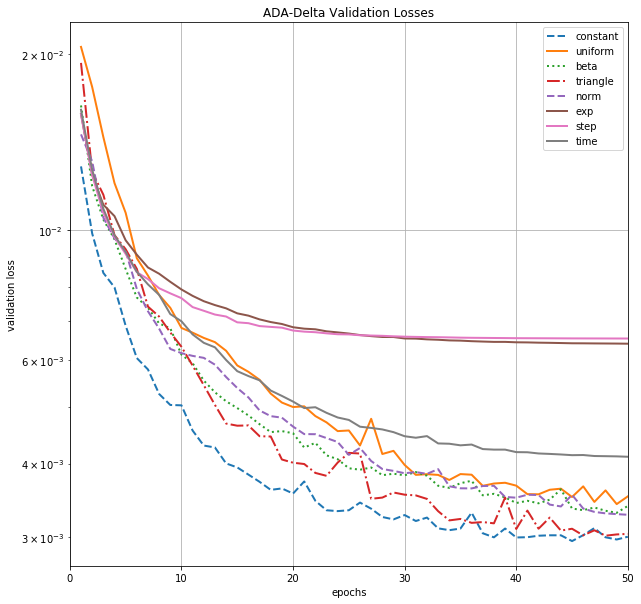

In [100]:
#Master plots- Validation

constant1 = pickle.load(open('adad/constant_trainHistoryDict','rb'))
uniform = pickle.load(open("adad/uni_decay_trainHistoryDict","rb"))
triangle = pickle.load(open("adad/tri_decay_trainHistoryDict","rb"))
norm = pickle.load(open("adad/norm_decay_trainHistoryDict","rb"))
beta = pickle.load(open("adad/beta_decay_trainHistoryDict","rb"))
exp = pickle.load(open('adad/exp_decay_trainHistoryDict','rb'))
time = pickle.load(open('adad/time_decay_trainHistoryDict','rb'))
step = pickle.load(open('adad/step_decay_trainHistoryDict','rb'))

#Plot accuracies
fig = plt.figure(figsize=(10,10))
plt.plot(range(1,epochs+1),constant1['val_acc'],label='constant', linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),uniform['val_acc'],label='uniform',  linestyle='-', linewidth = 2)
plt.plot(range(1,epochs+1),triangle['val_acc'],label='beta', linestyle=':', linewidth = 2)
plt.plot(range(1,epochs+1),norm['val_acc'],label='triangle',  linestyle='-.', linewidth = 2)
plt.plot(range(1,epochs+1),beta['val_acc'],label='normal',  linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),step['val_acc'],label='step', linewidth = 2)
plt.plot(range(1,epochs+1),time['val_acc'],label='time', linewidth = 2)
plt.plot(range(1,epochs+1),exp['val_acc'],label='exponential', linewidth = 2)
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.xlim([0,epochs])
#plt.yscale("log")

#     plt.ylim([0,1])
plt.grid(True)
plt.title("ADA-Delta Validation Accuracies")
plt.show()
fig.savefig('adad/validation_accuracies.png')
plt.close(fig)


#Plot losses
fig = plt.figure(figsize=(10,10))
plt.plot(range(1,epochs+1),constant1['val_loss'],label='constant', linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),uniform['val_loss'],label='uniform',  linestyle='-', linewidth = 2)
plt.plot(range(1,epochs+1),triangle['val_loss'],label='beta', linestyle=':', linewidth = 2)
plt.plot(range(1,epochs+1),norm['val_loss'],label='triangle',  linestyle='-.', linewidth = 2)
plt.plot(range(1,epochs+1),beta['val_loss'],label='norm',  linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),exp['val_loss'],label='exp', linewidth = 2)
plt.plot(range(1,epochs+1),step['val_loss'],label='step', linewidth = 2)
plt.plot(range(1,epochs+1),time['val_loss'],label='time', linewidth = 2)
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.xlim([0,epochs])
plt.yscale("log")

#     plt.ylim([0,1])
plt.grid(True)
plt.title("ADA-Delta Validation Losses")
plt.show()
fig.savefig('adad/validation_losses.png')
plt.close(fig)


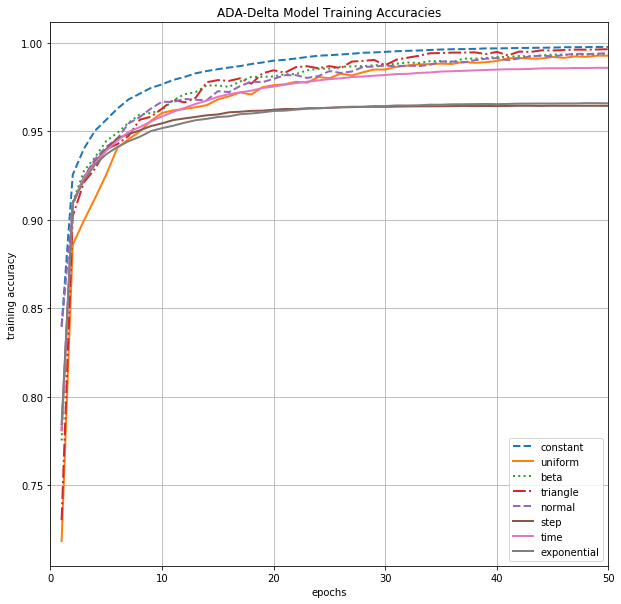

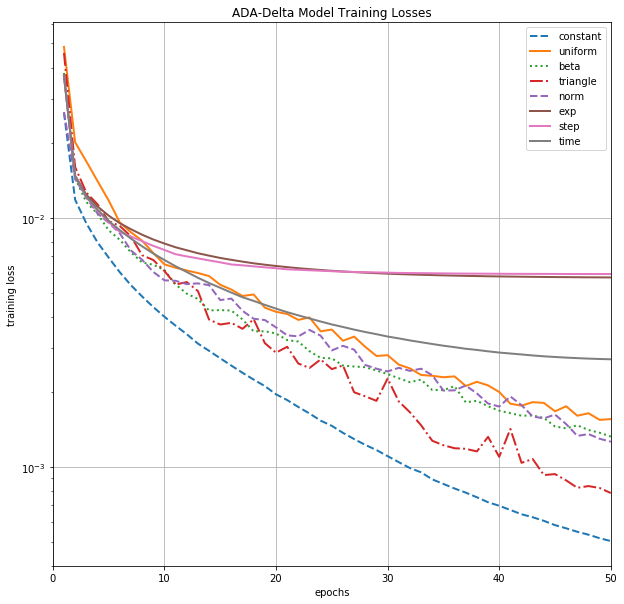

In [121]:
#Master plots - Training

constant1 = pickle.load(open('adad/constant_trainHistoryDict','rb'))
uniform = pickle.load(open("adad/uni_decay_trainHistoryDict","rb"))
triangle = pickle.load(open("adad/tri_decay_trainHistoryDict","rb"))
norm = pickle.load(open("adad/norm_decay_trainHistoryDict","rb"))
beta = pickle.load(open("adad/beta_decay_trainHistoryDict","rb"))
exp = pickle.load(open('adad/exp_decay_trainHistoryDict','rb'))
time = pickle.load(open('adad/time_decay_trainHistoryDict','rb'))
step = pickle.load(open('adad/step_decay_trainHistoryDict','rb'))

#Plot accuracies
fig = plt.figure(figsize=(10,10))
plt.plot(range(1,epochs+1),constant1['acc'],label='constant', linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),uniform['acc'],label='uniform',  linestyle='-', linewidth = 2)
plt.plot(range(1,epochs+1),triangle['acc'],label='beta', linestyle=':', linewidth = 2)
plt.plot(range(1,epochs+1),norm['acc'],label='triangle',  linestyle='-.', linewidth = 2)
plt.plot(range(1,epochs+1),beta['acc'],label='normal',  linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),step['acc'],label='step', linewidth = 2)
plt.plot(range(1,epochs+1),time['acc'],label='time', linewidth = 2)
plt.plot(range(1,epochs+1),exp['acc'],label='exponential', linewidth = 2)
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.xlim([0,epochs])
#plt.yscale("log")

#     plt.ylim([0,1])
plt.grid(True)
plt.title("ADA-Delta Model Training Accuracies")
plt.show()
fig.savefig('adad/training_accuracies.png')
plt.close(fig)


#Plot losses
fig = plt.figure(figsize=(10,10))
plt.plot(range(1,epochs+1),constant1['loss'],label='constant', linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),uniform['loss'],label='uniform',  linestyle='-', linewidth = 2)
plt.plot(range(1,epochs+1),triangle['loss'],label='beta', linestyle=':', linewidth = 2)
plt.plot(range(1,epochs+1),norm['loss'],label='triangle',  linestyle='-.', linewidth = 2)
plt.plot(range(1,epochs+1),beta['loss'],label='norm',  linestyle='--', linewidth = 2)
plt.plot(range(1,epochs+1),exp['loss'],label='exp', linewidth = 2)
plt.plot(range(1,epochs+1),step['loss'],label='step', linewidth = 2)
plt.plot(range(1,epochs+1),time['loss'],label='time', linewidth = 2)
plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.xlim([0,epochs])
plt.yscale("log")

#     plt.ylim([0,1])
plt.grid(True)
plt.title("ADA-Delta Model Training Losses")
plt.show()
fig.savefig('adad/training_losses.png')
plt.close(fig)

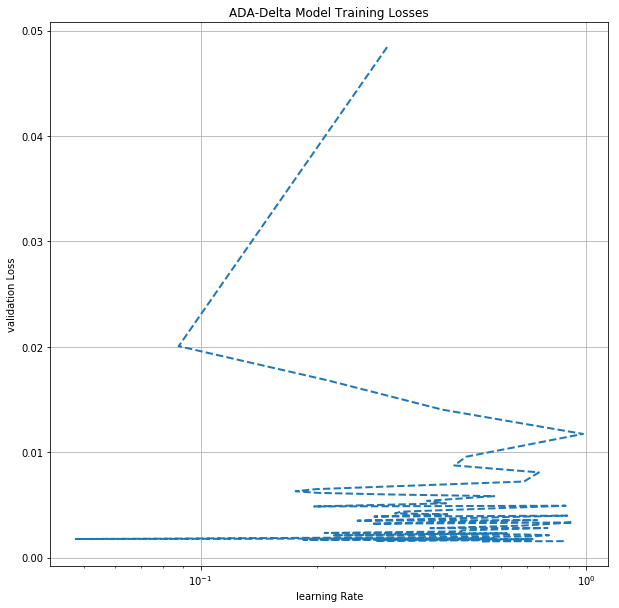

In [125]:
beta_historyDict = pickle.load(open('adad/uni_decay_trainHistoryDict','rb'))
beta_lrateDict = pickle.load(open('adad/uni_decay_learningRateArray','rb'))

fig = plt.figure(figsize=(10,10))
plt.plot(beta_lrateDict,beta_historyDict['loss'],linestyle='--', linewidth = 2)

plt.legend(loc=0)
plt.xlabel('learning Rate')
plt.ylabel('validation Loss')

plt.xscale("log")

#     plt.ylim([0,1])
plt.grid(True)
plt.title("ADA-Delta Model Training Losses")
plt.show()
#fig.savefig('adad/training_losses.png')
plt.close(fig)
